# In this Notebook, I have created a search engine that looks through the Collection of StackOverFlow Python Questions(collected between 2008-2016) and retrieves the Questions most similar to input python related question.   

In [1]:


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

##%%

!pip install transformers

In [2]:
!pip install simpletransformers==0.32.3

In [3]:
!pip install wordcloud

In [4]:
!pip install torch

In [5]:
import pandas as pd
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
from transformers import (GPT2Config,GPT2LMHeadModel,GPT2Tokenizer)
from tqdm.notebook import tqdm
import torch

pd.set_option('display.max_colwidth', -1)

<ipython-input-5-c04737093b4f>:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedecabre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
questions = pd.read_csv("input/Questions.csv", encoding = "ISO-8859-1")
print(len(questions))
display(questions.head(5))

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'],
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=10000
                          )

607282


,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from its display name on a Mac?,"<p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>\n\n<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>\n\n<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>\n\n<ul>\n<li>Some Photoshop javascript</li>\n<li>A Python function</li>\n<li>An OSX API that I can call from python</li>\n</ul>\n"
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,"<p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>\n\n<p>On the Mac I am spawning <a href=""http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html"">sips</a>. Is there something similarly simple I can do on Windows?</p>\n"
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Codebase,"<p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending nag e-mails to responsible persons when the tests fail) similar to CruiseControl or TeamCity.</p>\n\n<p>I realize I could do this with hooks in most VCSes, but that requires that the tests run on the same machine as the version control server, which isn't as elegant as I would like. Does anyone have any suggestions for a small, user-friendly, open-source continuous integration system suitable for a Python codebase?</p>\n"
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a result set. What are the tradeoff of each?</p>\n
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python objects in an array,"<p>I don't remember whether I was dreaming or not but I seem to recall there being a function which allowed something like,</p>\r\n\r\n<pre><code>foo in iter_attr(array of python objects, attribute name)</code></pre>\r\n\r\n<p>I've looked over the docs but this kind of thing doesn't fall under any obvious listed headers</p>"


In [45]:
print("Number of unique Questions : ", df_questions['Id'].nunique())

Number of unique Questions :  990


In [47]:
df_questions['qText'] = df_questions['Text'].apply(lambda x : len(x.split(" ")))

## Number of words in Title and Body

Text(0.5, 1.0, 'No. of words in Texte')

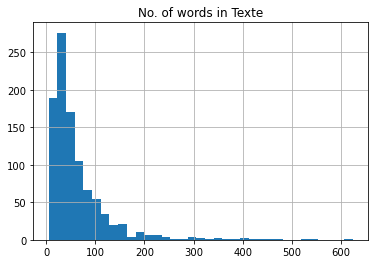

In [48]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qText'].hist(bins=35)
plt.title("No. of words in Texte")

## Most of the Titles have around 7 words while for Body it stands at around 50. So, to get the most similar questions I will use Title instead  of Body.

## Word Cloud

In [12]:
def getWordCloud(df,col):
    comment_words = '' 
    stopwords = set(STOPWORDS) 
    
    for val in tqdm(df[col]): 
        
        val = str(val) 
        tokens = val.split() 
        
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = stopwords, 
                  min_font_size = 10).generate(comment_words) 
    
                       
    plt.figure(figsize = (5, 5), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.tight_layout(pad = 0) 
    
    plt.show()

  0%|          | 0/990 [00:00<?, ?it/s]

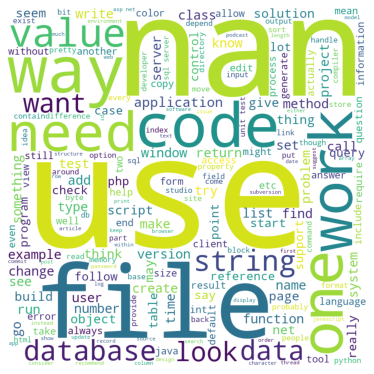

In [49]:
getWordCloud(df_questions,'Text')

## Preprocessing the title -- Removal of Stop Words, non alphanumeric charcters, and lower case all the charcters.

In [14]:
stop = stopwords.words('english')
def preprocess(df, col):
    df['preprocessed'+col] = df[col].apply(lambda x : " ".join([word for word in x.split(" ") if word not in stop]))
    df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')
    df['preprocessed'+col] = df['preprocessed'+col].str.lower()
    return df

In [15]:
questions = preprocess(questions, 'Title')

<ipython-input-14-9fa6568cbb61>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')


## Tags

In [16]:
tags = pd.read_csv("input/Tags.csv", encoding = "ISO-8859-1")
print(len(tags))
display(tags.head(5))

1885078


,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [17]:
print("Number of unique Tags : ", tags['Tag'].nunique())

Number of unique Tags :  16895


## 20  Most frequent Tags Except Python which is obviously the most frequent.

<AxesSubplot:>

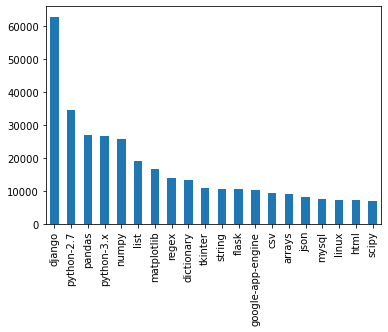

In [18]:
fig, ax = plt.subplots()
tags[tags['Tag']!='python']['Tag'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')

## Encoding the Processed Question Title and Embedding it using GPT2 Tokenizer. 

In [19]:
config_class, model_class, tokenizer_class = GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
model = model_class.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [20]:
preprocessedTitle = questions['preprocessedTitle'].values
QID = questions['Id'].values
print(len(preprocessedTitle), len(QID))

607282 607282


## Using tokenizer.batch_encode_plus to encode all the titles in 1 go. Instead of tokenizer.batch_encode_plus, tokenizer.encode can be used to encode 1 instance at a time

In [21]:
encodedpreprocessedTitle = tokenizer.batch_encode_plus(preprocessedTitle)['input_ids']
print(len(encodedpreprocessedTitle))

607282


## Loading the embedding from GPT2 Model. Each token in the embedding matrix is 768 length vector and the embedding has 50257 unique tokens.

In [22]:
embeddigs = model.transformer.wte
print("Shape of embedding matrix : ",embeddigs.weight.shape)
print("Type of embedding matrix : ", type(embeddigs))

Shape of embedding matrix :  torch.Size([50257, 768])
Type of embedding matrix :  <class 'torch.nn.modules.sparse.Embedding'>


## In the below code, I have taken the mean across embeddings of all the tokens in a particular Title. So after taking the mean every Title would be represented by a 768 length vector. And this same thing has been done for all the 607282 Titles in the for loop. 
## Note -- There might be cases where number of tokens in the processed Title can be 0, hence the condition of len(encodedTitle) > 0 has been applied.

In [23]:
TitleEmbeddingList = []
QIDList = []
for idx, (qid, encodedTitle) in tqdm(enumerate(zip(QID, encodedpreprocessedTitle))):
    if len(encodedTitle) > 0 :
        embeddedTitle = embeddigs(torch.tensor(encodedTitle).to(torch.int64)).mean(axis=0)
        TitleEmbeddingList.append(embeddedTitle)
        QIDList.append(qid)

0it [00:00, ?it/s]

In [24]:
numQ = len(TitleEmbeddingList)
embedDim = len(TitleEmbeddingList[0])
print("Number of Titles : ",numQ," and Length of vector of each Title : ",embedDim)

Number of Titles :  607281  and Length of vector of each Title :  768


In [25]:
print("Type of TitleEmbeddingList : ",type(TitleEmbeddingList))

Type of TitleEmbeddingList :  <class 'list'>


## Converting  TitleEmbeddingList from List of tensors to tensor.

In [26]:
TitleEmbeddingTensor = torch.cat(TitleEmbeddingList, dim=0)
TitleEmbeddingTensor = torch.reshape(TitleEmbeddingTensor, (numQ, embedDim))
print("Shape of TitleEmbeddingTensor : ",TitleEmbeddingTensor.shape)
print("Type of TitleEmbeddingTensor : ", type(TitleEmbeddingTensor))

Shape of TitleEmbeddingTensor :  torch.Size([607281, 768])
Type of TitleEmbeddingTensor :  <class 'torch.Tensor'>


# Once we created the embedding representation of each title. Now we are going to feed in an input question and search among StackOverflow Question Titles which ones are most similar to the input by using cosine similarity between embedding of input question and the titles. 

## PreProcess the Input text

In [27]:
def preprocesstext(text):
    text =  " ".join([word for word in text.split(" ") if word not in stop])
    text = re.sub(r'[^a-zA-Z0-9 ]','',text)
    text = text.lower()
    return text

## Perform Cosine Similarity between the input question and all the StackOverFlow Titles and Get index of the most simillar K Titles 

In [28]:
def getMostSimilarQuestionsIdx(K, a, b):
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    res = torch.mm(a_norm, b_norm.transpose(0,1)).squeeze(0)
    res = res.tolist()
    mostSimIdx = sorted(range(len(res)), key=lambda x: res[x])[-K:]
    return mostSimIdx

## Print out the Most Similar Question Titles With the Question ID

In [29]:
def getMostSimilarQuestions(K, input, QuestionDF, QIDList):
    input = input
    preprocessedinput = preprocesstext(input)
    inputEncoded = tokenizer.batch_encode_plus([preprocessedinput])['input_ids']
    inputEmbedded = embeddigs(torch.tensor(inputEncoded).to(torch.int64)).squeeze(0).mean(axis=0).unsqueeze(0)
    mostSimilarIdx = getMostSimilarQuestionsIdx(K, inputEmbedded, TitleEmbeddingTensor)
    mostSimilarIdx.reverse()
    print("Most similar ",K, " questions : ")
    for idx, simidx in enumerate(mostSimilarIdx):
        IDQ = QuestionDF[QuestionDF['Id']==QIDList[simidx]][['Id','Title']].values
        parentId = IDQ[0][0]
        simQuestion = IDQ[0][1]
        print((idx+1), "Question Id : ", parentId, "Question : ",simQuestion)

## Lets test !!!

In [30]:
getMostSimilarQuestions(5, "How to MUltiply 2 columns pandas ?", questions ,QIDList)

Most similar  5  questions : 
1 Question Id :  29229892 Question :  How can I multiply each column with the other columns of the Pandas DataFrame?
2 Question Id :  30224626 Question :  How can I join columns in Pandas?
3 Question Id :  37929109 Question :  How to merge / overwrite columns in Pandas
4 Question Id :  38026984 Question :  How do I calculate a pandas column with multiple columns as arguments?
5 Question Id :  19221694 Question :  How many columns in pandas, python?


In [31]:
getMostSimilarQuestions(5, "regex pandas", questions ,QIDList)

Most similar  5  questions : 
1 Question Id :  34375898 Question :  REGEX using Pandas
2 Question Id :  39125455 Question :  Regex with columns pandas
3 Question Id :  36360828 Question :  Regex Difficulties Extracting Text for Pandas Dataframe
4 Question Id :  31271146 Question :  In Pandas module of python pandas.read_excel is not working
5 Question Id :  38336727 Question :  regex and python


In [32]:
getMostSimilarQuestions(5, "logistic regression sklearn", questions ,QIDList)

Most similar  5  questions : 
1 Question Id :  32724678 Question :  Logistic Regression with sklearn
2 Question Id :  40067172 Question :  Logistic Regression model on sklearn
3 Question Id :  24935415 Question :  Logistic Regression function on sklearn
4 Question Id :  20869711 Question :  Features in sklearn logistic regression
5 Question Id :  34033189 Question :  sklearn Python and Logistic regression


In [33]:
getMostSimilarQuestions(5, "covert csv to json file pandas", questions ,QIDList)

Most similar  5  questions : 
1 Question Id :  23057219 Question :  how to convert csv to dictionary using pandas
2 Question Id :  30132999 Question :  convert whole csv to json file- python
3 Question Id :  23231605 Question :  Convert Pandas dataframe to csv string
4 Question Id :  35515367 Question :  Convert a single string formatted as a csv file into a pandas dataframe
5 Question Id :  38291701 Question :  Using pandas over csv library for manipulating CSV files in Python3


In [34]:
getMostSimilarQuestions(5, "Build website using python", questions ,QIDList)

Most similar  5  questions : 
1 Question Id :  4828238 Question :  Connect to a website using Python
2 Question Id :  34830638 Question :  Build a URL using Python requests library
3 Question Id :  23691606 Question :  Build a URL using Requests module Python
4 Question Id :  31333864 Question :  login into a website using python
5 Question Id :  14424858 Question :  how to login into a website using python


In [35]:
getMostSimilarQuestions(5, "How to install Pandas", questions ,QIDList)

Most similar  5  questions : 
1 Question Id :  31211853 Question :  How to install Python Pandas?
2 Question Id :  38768996 Question :  How to install pandas for Python 3?
3 Question Id :  22924370 Question :  How to make this pandas query?
4 Question Id :  28560826 Question :  How do I install pandas for Python 3.4 in Windows?
5 Question Id :  39286344 Question :  How to use merge in pandas
